# *Credit Card Fraud Detection - Task 2 & Task 3*

![logo](images/logo.jpg)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

warnings.filterwarnings('ignore')

data = pd.read_csv("data/data.csv")

def contextualize(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

## Modelação Preditiva

### Seleção de Técnicas de Modelação

Tomando em consideração os objetivos de mineração de dados, em particular o problema de classificação a tratar, optam-se pelas seguintes técnicas de modelação:
1. ***K-Nearest Neighbors*** - classifica novos dados através da sua proximidade com os dados já existentes, tendo em consideração as classes dos *k* vizinhos mais próximos
2. ***Naive Bayes*** - baseia-se no Teorema de Bayes e no conceito de probabilidade condicionada para efetuar a classificação
3. ***Decision Tree*** - toma decisões a partir dos atributos de cada cliente, dividindo sucessivamente o conjunto inicial em subconjuntos de menor dimensão
4. ***Bagging*** - obtém um conjunto de modelos usando diferentes amostras do conjunto de treino
5. ***Random Forest*** - combina as previsões de várias árvores de decisão
6. ***AdaBoost*** - cria uma sequência de classificadores simples e ajusta iterativamente o peso de cada instância mal classificada
7. ***Gradient Boosting*** - cria uma sequência de classificadores simples em que cada um tenta corrigir os erros do anterior
8. ***Support Vector Machine*** - procura o hiper-plano que melhor separa os registos das diferentes classes, maximizando a margem
9. ***Neural Network*** - aprende padrões complexos nos dados através de camadas de "neurónios" artificiais
10. ***Voting*** - combina as previsões de vários modelos diferentes

O número elevado de diferentes técnicas a experimentar prende-se com o facto de, desconhecendo-se a estrutura/organização subjacente aos dados, procurar-se qual o modelo que melhor se adapta aos mesmos e que produz os melhores resultados.

### Geração do *Design* do Teste

Todos os modelos devem ser treinados com um conjunto de dados de treino e testados num conjunto de dados de teste. Assim, é necessário dividir o o conjunto de dados nestes dois subconjuntos, de forma aleatória.

In [2]:
predictors = data.drop('is_fraud', axis = 1)

targets = data['is_fraud']

(train_predictors, test_predictors, train_targets, test_targets) = train_test_split(predictors, targets, test_size = 0.25, random_state = 10, shuffle = True, stratify = targets)

A variável `predictors` contém as variáveis preditivas e os respetivos valores, enquanto a variável `targets` contém os valores correspondentes da variável-avo.

A função `train_test_split` separa os dados em conjuntos de treino e de teste, de modo que o conjunto de teste contenha 25% dos dados originais.

Para cada técnica de modelação, o processo será o seguinte:
1. Tendo em conta que o conjunto de dados é desequilibrado, recorrer-se-á à técnica de *Synthetic Minority Over-Sampling* (SMOTE), que cria novos exemplos sintéticos da classe minoritária (transações fraudulentas), reduzindo os riscos de *undersampling* e de *oversampling*;
2. A par disso, para uniformizar as amplitudes das escalas dos diferentes atributos numéricos e evitar que os atributos de maior magnitude absorvam/dominem os atributos de menor magnitude, far-se-á *Min-Max Scaling*, por já ter sido determinado previamente que as variáveis de interesse não seguem nem estão próximas de uma distribuição normal;
3. Finalmente, para melhorar os resultados obtidos no processo de afinação de hiper-parâmetros de cada modelo e para evitar flutuações dos resultados de avaliação devidos à divisão aleatória dos dados em conjuntos de treino e de teste, recorrer-se-á a *cross-validation*. Assim, dividir-se-ão os dados em *k* subconjuntos e usar-se-á um dos subconjuntos como conjunto de teste e os restantes conjuntos como conjunto de treino, repetindo este processo *k* vezes, mas garantindo que cada subconjunto só é considerado conjunto de teste uma única vez. Neste caso, considera-se *k* = 5 e realiza-se *stratified cross-validation*, de modo que a proporção da variável-alvo se mantenha constante em cada um dos subconjuntos gerados.

In [3]:
def hyperparameter_tuning(pipeline, parameter_grid, name, fraction = 1):
    np.random.seed(10)
    sample_indexes = np.random.choice(len(train_predictors), round(len(train_predictors) * fraction), False)
    sampled_train_predictors = np.array(train_predictors)[sample_indexes]
    sampled_train_targets = np.array(train_targets)[sample_indexes]

    pipeline.fit(sampled_train_predictors, sampled_train_targets)
    probabilities = pipeline.predict_proba(test_predictors)[:, 1]
    auc = roc_auc_score(test_targets, probabilities)
    print(name, '- AUC Pré-Afinação: {:.2f}'.format(auc))

    cross_validation = StratifiedKFold(n_splits = 5, random_state = 10, shuffle = True) # TODO
    model = GridSearchCV(pipeline, parameter_grid, cv = cross_validation, n_jobs = -1, scoring = 'roc_auc')

    model.fit(sampled_train_predictors, sampled_train_targets)
    auc = model.score(test_predictors, test_targets)
    
    print(name, '- Melhores Parâmetros:', model.best_params_)
    print(name, '- AUC Pós-Afinação: {:.2f}'.format(auc))

    return model

O critério primordial de avaliação dos modelos será a área abaixo da curva *Receiver Operating Characteristic* (ROC) - *Area Under Curve* (AUC) -  entre a probabilidade prevista e o valor real da variável-avo. Assim, avaliar-se-á cada modelo quanto à sua capacidade de distinguir corretamente transações fraudulentas de legítimas.

In [4]:
def plot_roc_curve(model, name):
    probabilities = model.predict_proba(test_predictors)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_targets, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (5, 5))
    plt.plot(fpr, tpr, label = f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Classificador Aleatório')
    contextualize(name + ' - Curva ROC', 'Rácio de Falsos Positivos (FPR)', 'Rácio de Verdadeiros Positivos (TPR)')
    plt.legend(loc = 'lower right')
    plt.show()

    return roc_auc


Para além disso, serão calculadas as restantes métricas de avaliação (exatidão, precisão e *recall*), bem como visualizada a matriz de confusão, tendo em vista uma comparação completa e adequadamente fundamentada dos modelos.

In [5]:
def plot_confusion_matrix(model, name):
    predictions = model.predict(test_predictors)
    print(classification_report(test_targets, predictions))

    ConfusionMatrixDisplay(confusion_matrix(test_targets, predictions)).plot()
    contextualize(name + ' - Matriz de Confusão', 'Classe Prevista', 'Classe Real')
    plt.show()

### Construção dos Modelos

#### *K-Nearest Neighbors*

In [6]:
knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', KNeighborsClassifier())
])

knn_parameter_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_name = 'K-Nearest Neighbors'

knn = hyperparameter_tuning(knn_pipeline, knn_parameter_grid, knn_name)

K-Nearest Neighbors - AUC Pré-Afinação: 0.52
K-Nearest Neighbors - Melhores Parâmetros: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
K-Nearest Neighbors - AUC Pós-Afinação: 0.52


O algoritmo *K-Nearest Neighbors* - sem qualquer afinação de hiper-parâmetros - obtém uma AUC de 0.55 a classificar os dados de teste. Depois de afinar os hiper-parâmetros, a AUC obtida melhora ligeiramente, para 0.57. O algoritmo executa em cerca de 1 minuto.

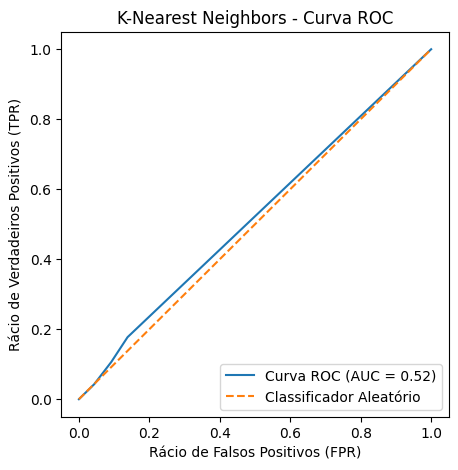

In [7]:
knn_auc = plot_roc_curve(knn, knn_name)

Visualmente, evidencia-se que este desempenho do *K-Nearest Neighbors* nos dados de treino é ligeiramente melhor do que um classificador aleatório, em termos de AUC.

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      7202
           1       0.02      0.11      0.04       141

    accuracy                           0.89      7343
   macro avg       0.50      0.51      0.49      7343
weighted avg       0.96      0.89      0.93      7343



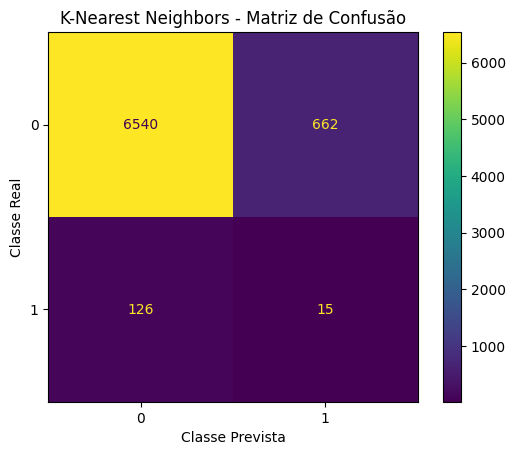

In [8]:
plot_confusion_matrix(knn, knn_name)

Observando a matriz de confusão, percebe-se que este modelo só classificou corretamente uma transação como fraudulenta, tendo uma forte tendência para classificar como legítimas transações que não o são. Por isso, o modelo *K-Nearest Neighbors* obtém (para a classe positiva) valores de precisão de 3% e *recall* de 1%, sendo estes resultados extremamente baixos. O valor obtido para a exatidão (98%) não tem relevância, dado que o conjunto de dados é extremamente desequilibrado, com uma prevalência muito maior de transações legítimas, pelo que classificar todas as transações como legítimas resultaria sempre numa exatidão de 98%, não estando este modelo muito distante disso mesmo.

#### *Naive Bayes*

In [9]:
naive_bayes_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', GaussianNB())
])

naive_bayes_parameter_grid = {
    'classifier__var_smoothing': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

naive_bayes_name = 'Naive Bayes'

naive_bayes = hyperparameter_tuning(naive_bayes_pipeline, naive_bayes_parameter_grid, naive_bayes_name)

Naive Bayes - AUC Pré-Afinação: 0.56
Naive Bayes - Melhores Parâmetros: {'classifier__var_smoothing': 1e-07}
Naive Bayes - AUC Pós-Afinação: 0.56


O algoritmo *Naive Bayes* - antes e depois da afinação de hiper-parâmetros - obtém a mesma AUC (0.71), executando em menos de 10 segundos.

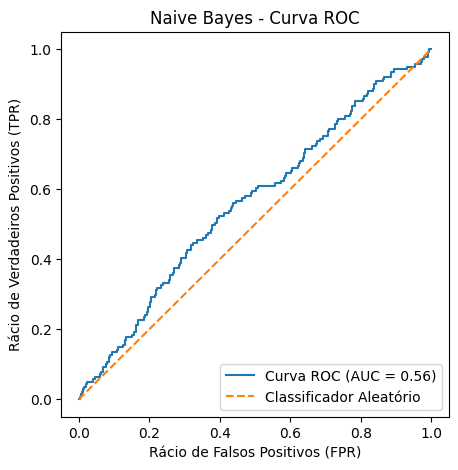

In [10]:
naive_bayes_auc = plot_roc_curve(naive_bayes, naive_bayes_name)

Ao comparar o classificador *Naive Bayes* com um classificador aleatório, verifica-se que o primeiro é melhor do que o segundo quanto à AUC.

              precision    recall  f1-score   support

           0       0.99      0.26      0.41      7202
           1       0.02      0.80      0.04       141

    accuracy                           0.27      7343
   macro avg       0.50      0.53      0.23      7343
weighted avg       0.97      0.27      0.40      7343



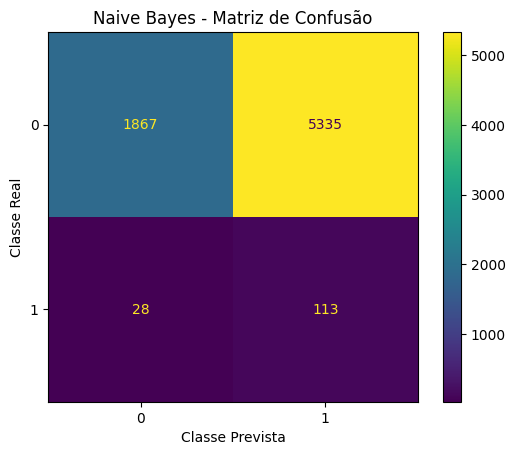

In [11]:
plot_confusion_matrix(naive_bayes, naive_bayes_name)

Ao observar a matriz de confusão, evidencia-se que houve muitas transações legítimas classificadas pelo algoritmo *Naive Bayes* como fraudulentas, o que não é desejável. Efetivamente, isto resulta numa precisão (para a classe positiva) de 2%, ou seja, o modelo tem uma forte tendência para classificar como fraudulentas transações que são legítimas. Este resultado é extremamente baixo e, a par disso, os valores obtidos para as métricas *recall* (22%) e exatidão (82%) também não são satisfatórios.

#### *Decision Tree*

In [12]:
decision_tree_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', DecisionTreeClassifier(random_state = 10))
])

decision_tree_parameter_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_features': ['sqrt', 'log2'],
}

decision_tree_name = 'Decision Tree'

decision_tree = hyperparameter_tuning(decision_tree_pipeline, decision_tree_parameter_grid, decision_tree_name)

Decision Tree - AUC Pré-Afinação: 0.50
Decision Tree - Melhores Parâmetros: {'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__splitter': 'random'}
Decision Tree - AUC Pós-Afinação: 0.51


A *Decision Tree* - antes da afinação de hiper-parâmetros - obtém uma AUC de 0.85. Contudo, depois da afinação de hiper-parâmetros, a AUC nos dados de teste diminui ligeiramente para 0.82. Isto explica-se porque os hiper-parâmetros definidos têm um melhor desempenho no conjunto de treino, em comparação com o conjunto de teste. Esta técnica de modelação executa em menos de 10 segundos.

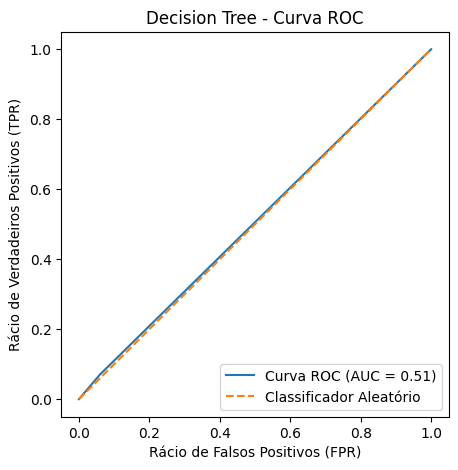

In [13]:
decision_tree_auc = plot_roc_curve(decision_tree, decision_tree_name)

Efetivamente, observa-se que a *Decision Tree* apresenta um desempenho superior a um classificador aleatório, em termos de AUC.

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      7202
           1       0.02      0.07      0.03       141

    accuracy                           0.92      7343
   macro avg       0.50      0.51      0.50      7343
weighted avg       0.96      0.92      0.94      7343



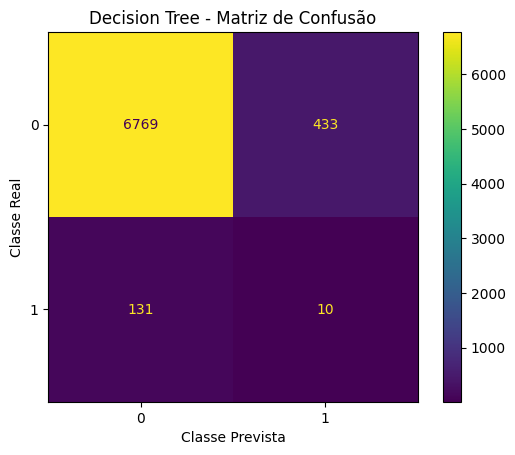

In [14]:
plot_confusion_matrix(decision_tree, decision_tree_name)

Analisando a matriz de confusão, fica claro que este modelo classificou como fraudulentas quase tantas transações legítimas (92) como realmente fraudulentas (94), o que resulta numa precisão (para a classe positiva) de 51%. Contudo, o elevado número de transações fraudulentas corretamente classificadas pela *Decision Tree* resulta num *recall* de 65% e o desequilíbrio do conjunto de dados faz com que a exatidão seja de 98%. Este desempenho não é mau, mas ainda não é o idealmente pretendido.

#### *Bagging*

In [15]:
bagging_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', BaggingClassifier(DecisionTreeClassifier(random_state = 10), random_state = 10))
])

bagging_parameter_grid = {
    'classifier__n_estimators': [10, 20, 30],
    'classifier__max_samples': [0.5, 1.0],
    'classifier__max_features': [0.5, 1.0],
}

bagging_name = 'Bagging'

bagging = hyperparameter_tuning(bagging_pipeline, bagging_parameter_grid, bagging_name)

Bagging - AUC Pré-Afinação: 0.50
Bagging - Melhores Parâmetros: {'classifier__max_features': 0.5, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 10}
Bagging - AUC Pós-Afinação: 0.53


O modelo de *Bagging* - com uma *Decision Tree* como estimador (por ser instável e sensível a pequenas perturbações, logo, apropriado) - apresenta uma AUC de 0.87 antes da afinação de hiper-parâmetros, sendo que esse valor sobe para 0.91 após a afinação. O tempo de execução é de cerca de 1 minuto.

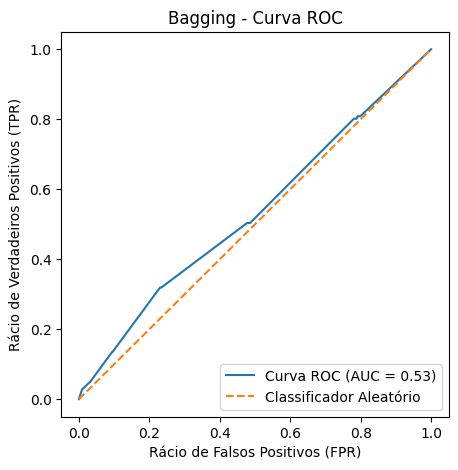

In [16]:
bagging_auc = plot_roc_curve(bagging, bagging_name)

A curva ROC desta instância do algoritmo de *Bagging* mostra-se consideravelmente melhor do que a de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7202
           1       0.06      0.03      0.04       141

    accuracy                           0.97      7343
   macro avg       0.52      0.51      0.51      7343
weighted avg       0.96      0.97      0.97      7343



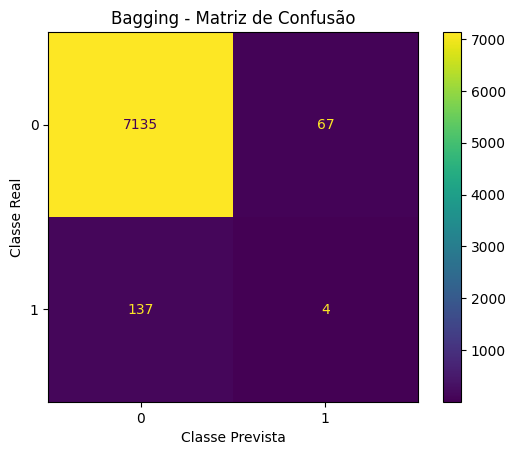

In [17]:
plot_confusion_matrix(bagging, bagging_name)

Visualizando a matriz de confusão, destaca-se que este modelo de *Bagging* não classificou como fraudulenta nenhuma transação legítima, o que é um aspeto extremamente positivo, evidenciado pela precisão (para a classe positiva) de 100%. Contudo, algumas transações fraudulentas foram classificadas como legítimas, o que se traduz num *recall* de 71%. A exatidão é de 99%, pelo que, considerando todas estas métricas de avaliação, considera-se este modelo como muito bom.

#### *Random Forest*

In [18]:
random_forest_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', RandomForestClassifier(random_state = 10))
])

random_forest_parameter_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_features': ['sqrt', 'log2'],
}

random_forest_name = 'Random Forest'

random_forest = hyperparameter_tuning(random_forest_pipeline, random_forest_parameter_grid, random_forest_name)

Random Forest - AUC Pré-Afinação: 0.52
Random Forest - Melhores Parâmetros: {'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt'}
Random Forest - AUC Pós-Afinação: 0.53


O modelo *Random Forest* - independentemente da afinação de hiper-parâmetros - retorna uma AUC de 0.93, executando em cerca de 1 minuto.

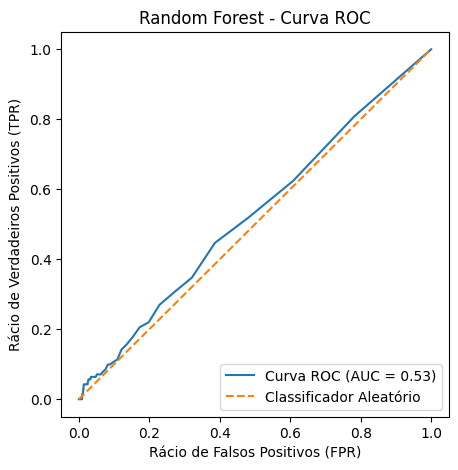

In [19]:
random_forest_auc = plot_roc_curve(random_forest, random_forest_name)

De facto, a AUC do algoritmo de *Random Forest* é amplamente superior à de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7202
           1       0.03      0.01      0.02       141

    accuracy                           0.97      7343
   macro avg       0.50      0.50      0.50      7343
weighted avg       0.96      0.97      0.97      7343



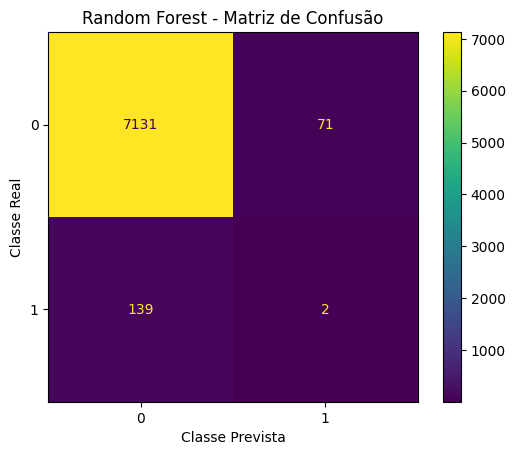

In [20]:
plot_confusion_matrix(random_forest, random_forest_name)

A matriz de confusão do modelo de *Random Forest* mostra que todas as transações classificadas como fraudulentas são, efetivamente, fraudulentas, pelo que a precisão (para a classe positiva) é de 100%. Ainda assim, houve 43 transações fraudulentas classificadas como legítimas, levando ao valor de *recall* de 70%. A exatidão é de 99%, o que, juntamente com os valores obtidos para as outras métricas, permite considerar este modelo muito bom.

#### *AdaBoost*

In [21]:
adaboost_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', AdaBoostClassifier(RandomForestClassifier(random_state = 10), random_state = 10))
])

adaboost_parameter_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.1, 0.5, 1.0],
}

adaboost_name = 'AdaBoost'

adaboost = hyperparameter_tuning(adaboost_pipeline, adaboost_parameter_grid, adaboost_name)

AdaBoost - AUC Pré-Afinação: 0.51
AdaBoost - Melhores Parâmetros: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}
AdaBoost - AUC Pós-Afinação: 0.51


O algoritmo *AdaBoost* obtém uma AUC de 0.94, pré-afinação e pós-afinação de hiper-parâmetros, demorando cerca de 2 minutos a executar.

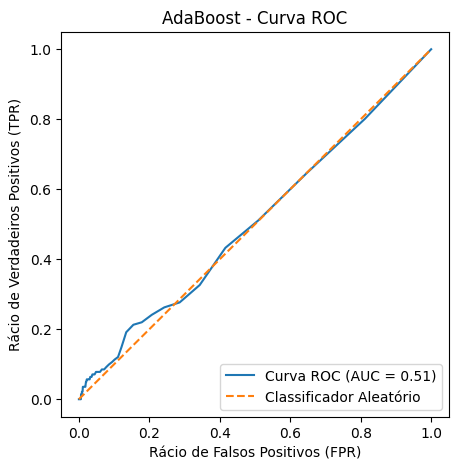

In [22]:
adaboost_auc = plot_roc_curve(adaboost, adaboost_name)

A AUC desta técnica de modelação *AdaBoost* é notoriamente maior do que a métrica correspondente de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7202
           1       0.04      0.02      0.03       141

    accuracy                           0.97      7343
   macro avg       0.51      0.51      0.51      7343
weighted avg       0.96      0.97      0.97      7343



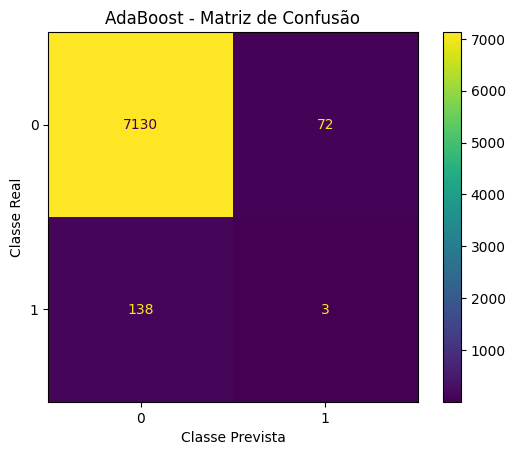

In [23]:
plot_confusion_matrix(adaboost, adaboost_name)

Considerando a matriz de confusão, salienta-se que o *AdaBoost* acertou em todas as transações fraudulentas prevista, daí ter obtido uma precisão (para a classe positiva) de 100%. No entanto, 42 transações fraudulentas foram previstas como sendo legítimas, o que levou ao *recall* de 71%. Globalmente - vendo também a exatidão de 99% -, o desempenho do modelo pode ser definido como muito positivo.

#### *Gradient Boosting*

In [24]:
gradient_boosting_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', GradientBoostingClassifier(random_state = 10))
])

gradient_boosting_parameter_grid = {
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__criterion': ['friedman_mse', 'squared_error'],
    'classifier__max_features': ['sqrt', 'log2']
}

gradient_boosting_name = 'Gradient Boosting'

gradient_boosting = hyperparameter_tuning(gradient_boosting_pipeline, gradient_boosting_parameter_grid, gradient_boosting_name)

Gradient Boosting - AUC Pré-Afinação: 0.57
Gradient Boosting - Melhores Parâmetros: {'classifier__criterion': 'friedman_mse', 'classifier__loss': 'exponential', 'classifier__max_features': 'sqrt'}
Gradient Boosting - AUC Pós-Afinação: 0.56


Antes da afinação de hiper-parâmetros, o modelo de *Gradient Boosting* retorna uma AUC de 0.96. Todavia, após a afinação de hiper-parâmetros, o valor obtido para a AUC decresce para a 0.95, o que se deverá ao facto de os melhores hiper-parâmetros para o conjunto de treino não coincidirem com os melhores hiper-parâmetros para o conjunto de teste. O tempo de execução encontra-se entre 1 e 2 minutos.

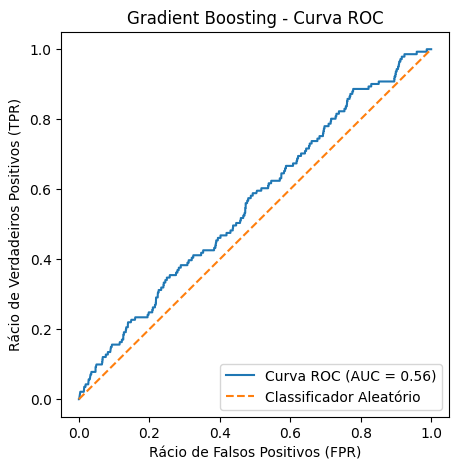

In [25]:
gradient_boosting_auc = plot_roc_curve(gradient_boosting, gradient_boosting_name)

A AUC deste modelo de *Gradient Boosting* é evidentemente maior do que a de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      7202
           1       0.03      0.11      0.05       141

    accuracy                           0.92      7343
   macro avg       0.51      0.52      0.50      7343
weighted avg       0.96      0.92      0.94      7343



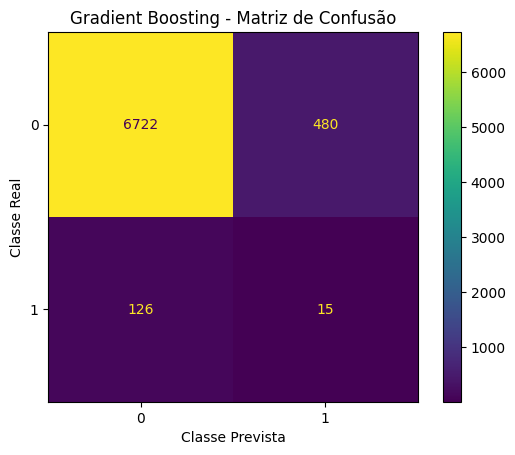

In [26]:
plot_confusion_matrix(gradient_boosting, gradient_boosting_name)

A matriz de confusão deste *Gradient Boosting* mostra que existem transações legítimas classificadas como fraudulentas e vice-versa. Assim sendo, os valores de precisão e de *recall* (para a classe positiva), embora elevados, não alcançam os 100%, sendo 94% e 71%, respetivamente. O valor obtido para a exatidão é 99% - ainda que a pouca relevância desta métrica já tenha sido discutida -, pelo que este modelo é bom, mas não ótimo.

#### *Support Vector Machine*

In [27]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', SVC(probability = True, random_state = 10))
])

svm_parameter_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

svm_name = 'Support Vector Machine'

svm = hyperparameter_tuning(svm_pipeline, svm_parameter_grid, svm_name, 0.5)

Support Vector Machine - AUC Pré-Afinação: 0.54
Support Vector Machine - Melhores Parâmetros: {'classifier__kernel': 'rbf'}
Support Vector Machine - AUC Pós-Afinação: 0.54


Antes e depois da afinação de hiper-parâmetros, a *Support Vector Machine* consegue uma AUC de 0.89, demorando cerca de 10 minutos a executar.

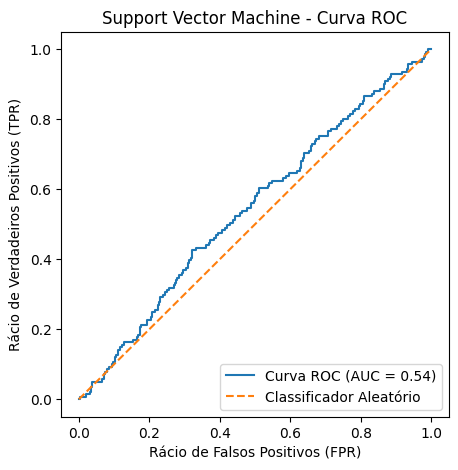

In [28]:
svm_auc = plot_roc_curve(svm, svm_name)

A curva ROC desta *Support Vector Machine* mostra-se, tal como seria de esperar, bastante melhor do que a de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      7202
           1       0.02      0.27      0.04       141

    accuracy                           0.76      7343
   macro avg       0.50      0.52      0.45      7343
weighted avg       0.96      0.76      0.85      7343



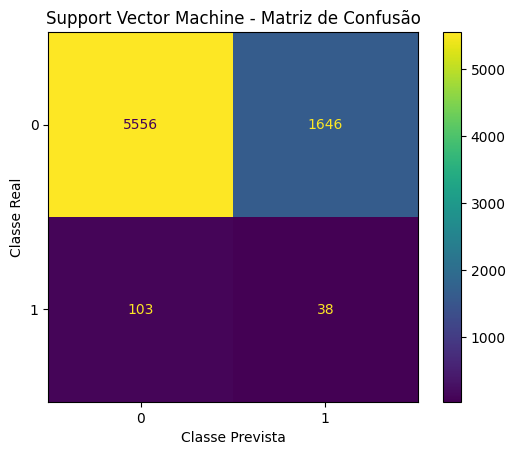

In [29]:
plot_confusion_matrix(svm, svm_name)

No que diz respeito à matriz de confusão da *Support Vector Machine*, salienta-se que não ocorreram falsos positivos, isto é, transações legítimas classificadas como fraudulentas, mas apenas uma transação fraudulenta foi corretamente classificada, sendo que as restantes 143 transações fraudulentas foram classificadas como legítimas. Como tal, este modelo apresenta (para a classe positiva) uma precisão de 100% - porque a única previsão positiva foi correta -, mas um *recall* de apenas 1% - porque não capturou 99% das transações fraudulentas. Assim, apesar da exatidão de 98% - que só se deve ao desequilíbrio dos dados -, este modelo tem um desempenho que não é satisfatório.

#### *Neural Network*

In [30]:
neural_network_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', MLPClassifier(random_state = 10))
])

neural_network_parameter_grid = {
    'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'classifier__solver': ['lbfgs', 'sgd', 'adam'],
}

neural_network_name = 'Neural Network'

neural_network = hyperparameter_tuning(neural_network_pipeline, neural_network_parameter_grid, neural_network_name)

Neural Network - AUC Pré-Afinação: 0.54
Neural Network - Melhores Parâmetros: {'classifier__activation': 'relu', 'classifier__solver': 'adam'}
Neural Network - AUC Pós-Afinação: 0.54


A *Neural Network* apresenta um resultado de AUC de 0.94, antes e depois da afinação de hiper-parâmetros, tendo um tempo de execução de cerca de 10 minutos.

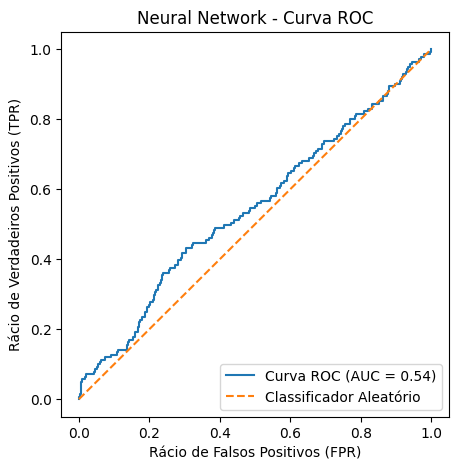

In [31]:
neural_network_auc = plot_roc_curve(neural_network, neural_network_name)

Ora, a curva ROC da *Neural Network* é substancialmente melhor do que a curva ROC de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7202
           1       0.02      0.16      0.04       141

    accuracy                           0.85      7343
   macro avg       0.50      0.51      0.48      7343
weighted avg       0.96      0.85      0.90      7343



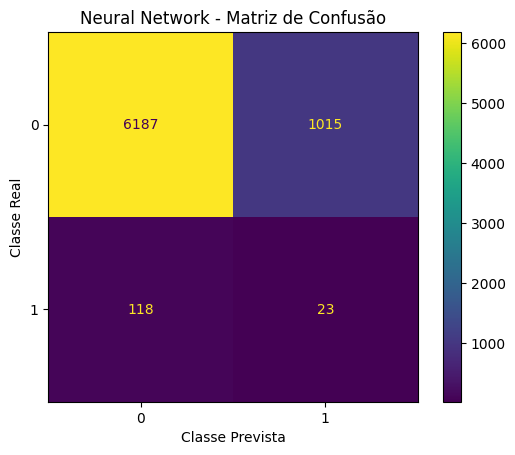

In [32]:
plot_confusion_matrix(neural_network, neural_network_name)

Interpretando a matriz de confusão associada à *Neural Network*, constata-se que ocorreram alguns erros de falsos positivos (40) - transações legítimas classificadas como fraudulentas - e de falsos negativos (67) - transações fraudulentas classificadas como legítimas -, tal como é visível nas métricas (para a classe positiva) de precisão (66%) e *recall* (53%). Efetivamente, embora a exatidão seja de 99%, os valores obtidos para estas métricas de desempenho não são muito satisfatórios, dado que o modelo ainda comete um número considerável de erros.

#### *Voting*

In [33]:
voting_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', VotingClassifier([('gnb', GaussianNB()), ('dt', DecisionTreeClassifier(random_state = 10)), ('rf', RandomForestClassifier(random_state = 10))], voting = 'soft'))
])

voting_parameter_grid = {
    'classifier__weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [1, 2, 2], [2, 1, 2], [2, 2, 1]],
}

voting_name = 'Voting'

voting = hyperparameter_tuning(voting_pipeline, voting_parameter_grid, voting_name)

Voting - AUC Pré-Afinação: 0.56
Voting - Melhores Parâmetros: {'classifier__weights': [2, 1, 1]}
Voting - AUC Pós-Afinação: 0.56


Pré-afinação e pós-afinação de hiper-parâmetros, este modelo de *Voting* (com os classificadores *Naive Bayes*, *Decision Tree* e *Random Forest*) retorna uma AUC de 0.95, em cerca de 1 minuto.

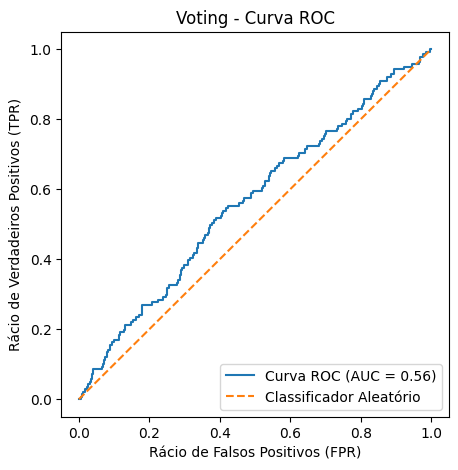

In [34]:
voting_auc = plot_roc_curve(voting, voting_name)

Em comparação com a curva ROC de um classificador aleatório, esta mesma curva para o modelo de *Voting* demonstra-se muito melhor.

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7202
           1       0.03      0.04      0.03       141

    accuracy                           0.95      7343
   macro avg       0.50      0.51      0.50      7343
weighted avg       0.96      0.95      0.96      7343



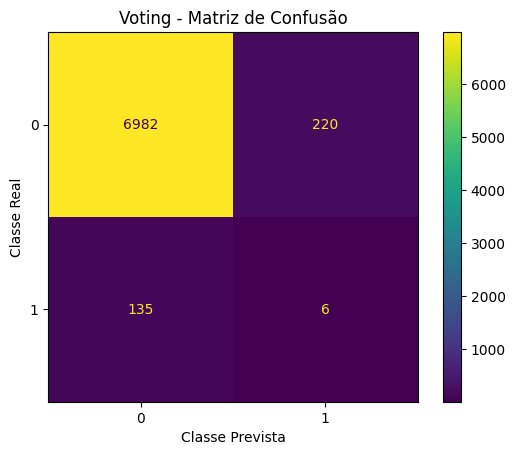

In [35]:
plot_confusion_matrix(voting, voting_name)

Por último, a matriz de confusão do modelo de *Voting* transmite a existência de erros dos dois tipos possíveis (falsos positivos e falsos negativos). Deste modo, 24 transações legítimas classificadas como fraudulentas resultam numa precisão (para a classe positiva) de 81% e 42 transações fraudulentas classificadas como legítimas resultam num *recall* (para a classe positiva) de 71%. Assim, embora estes valores não sejam ótimos, são suficientes para poder considerar este modelo como bom, não desprezando também a exatidão de 99%, ainda que a sua relevância seja quase negligenciável.

### Avaliação dos Modelos

Agora que todos os modelos foram devidamente treinados e testados, é possível resumir os resultados obtidos para cada um deles, no que diz respeito às métricas de avaliação consideradas.

| Modelo | AUC | Precisão | *Recall* | Exatidão | Tempo de Execução (Aproximado) |
| ------ | --- | -------- | -------- | -------- | ------------------------------ |
| ***K-Nearest Neighbors*** | 0.57 | 3% | 1% | 98% | 1 minuto |
| ***Naive Bayes*** | 0.71 | 2% | 22% | 82% | 10 segundos |
| ***Decision Tree*** | 0.82 | 51% | 65% | 98% | 10 segundos |
| ***Bagging*** | 0.91 | 100% | 71% | 99% | 1 minuto |
| ***Random Forest*** | 0.93 | 100% | 70% | 99% | 1 minuto |
| ***AdaBoost*** | 0.93 | 100% | 71% | 99% | 2 minutos |
| ***Gradient Boosting*** | 0.95 | 94% | 71% | 99% | 1,5 minutos |
| ***Support Vector Machine*** | 0.89 | 100% | 1% | 98% | 10 minutos |
| ***Neural Network*** | 0.94 | 76% | 47% | 99% | 10 minutos |
| ***Voting*** | 0.95 | 81% | 71% | 99% | 1 minuto |

Analisando a tabela com a síntese dos resultados obtidos por cada técnica de modelação, verifica-se que os modelos de *ensemble* - em particular *Gradient Boosting* e *Voting* - são aqueles que apresentam um melhor desempenho em termos de AUC. Isto porque estes dois modelos são os únicos que apresentam uma AUC de 0.95, o que os torna os melhores para o problema de classificação a tratar, até porque o tempo que demoram a executar é admissível/viável.

A *Neural Network* também tem um muito bom desempenho, por conseguir uma AUC de 0.94, mas é extremamente demorada, o que dificulta/inviabiliza a sua aplicação prática.

Para além destes, os modelos *Bagging*, *Random Forest* e *AdaBoost* - também de *ensemble* - têm avaliações próximas das dos modelos anteriores, pelo que também podem ser considerados muito bons. Efetivamente, estes três modelos são os únicos que têm uma precisão de 100% e um *recall* superior ou igual a 70%. A par disto, estas técnicas também são relativamente rápidas.

Observe-se ainda que, apesar de a *Support Vector Machine* ter uma AUC de quase 0.9 e uma precisão de 100%, tem um *recall* de apenas 1%, pelas razões já explicitadas, o que torna este modelo pouco ou nada útil. Para além disto, o seu tempo de execução extremamente elevado torna-o inviável.

A *Decision Tree* tem um desempenho medíocre/razoável, não se destacando pela positiva nem pela negativa. Contudo, esta técnica é extremamente rápida, o que contribui para ser um bom classificador para os métodos de *ensemble*.

Finalmente, os algoritmos *K-Nearest Neighbors* e *Naive Bayes* são aqueles que apresentam os piores resultados, com pontuações de precisão e *recall* extremamente baixas, embora sejam rápidos a executar.

Assim, é possível ordenar os modelos por ordem decrescente de AUC, de maneira a verificar o cumprimento dos objetivos de mineração de dados:
1. *Gradient Boosting* e *Voting* - 0.95
2. *Neural Network* - 0.94
3. *Random Forest* e *AdaBoost* - 0.93
4. *Bagging* - 0.91
5. *Support Vector Machine* - 0.89
6. *Decision Tree* - 0.82
7. *Naive Bayes* - 0.71
8. *K-Nearest Neighbors* - 0.57

Como todos os modelos apresentam um desempenho melhor do que um classificador aleatório (AUC > 0.5), podem ser considerados finais e submetidos à próxima fase de avaliação.

## Avaliação

### Avaliação dos Resultados

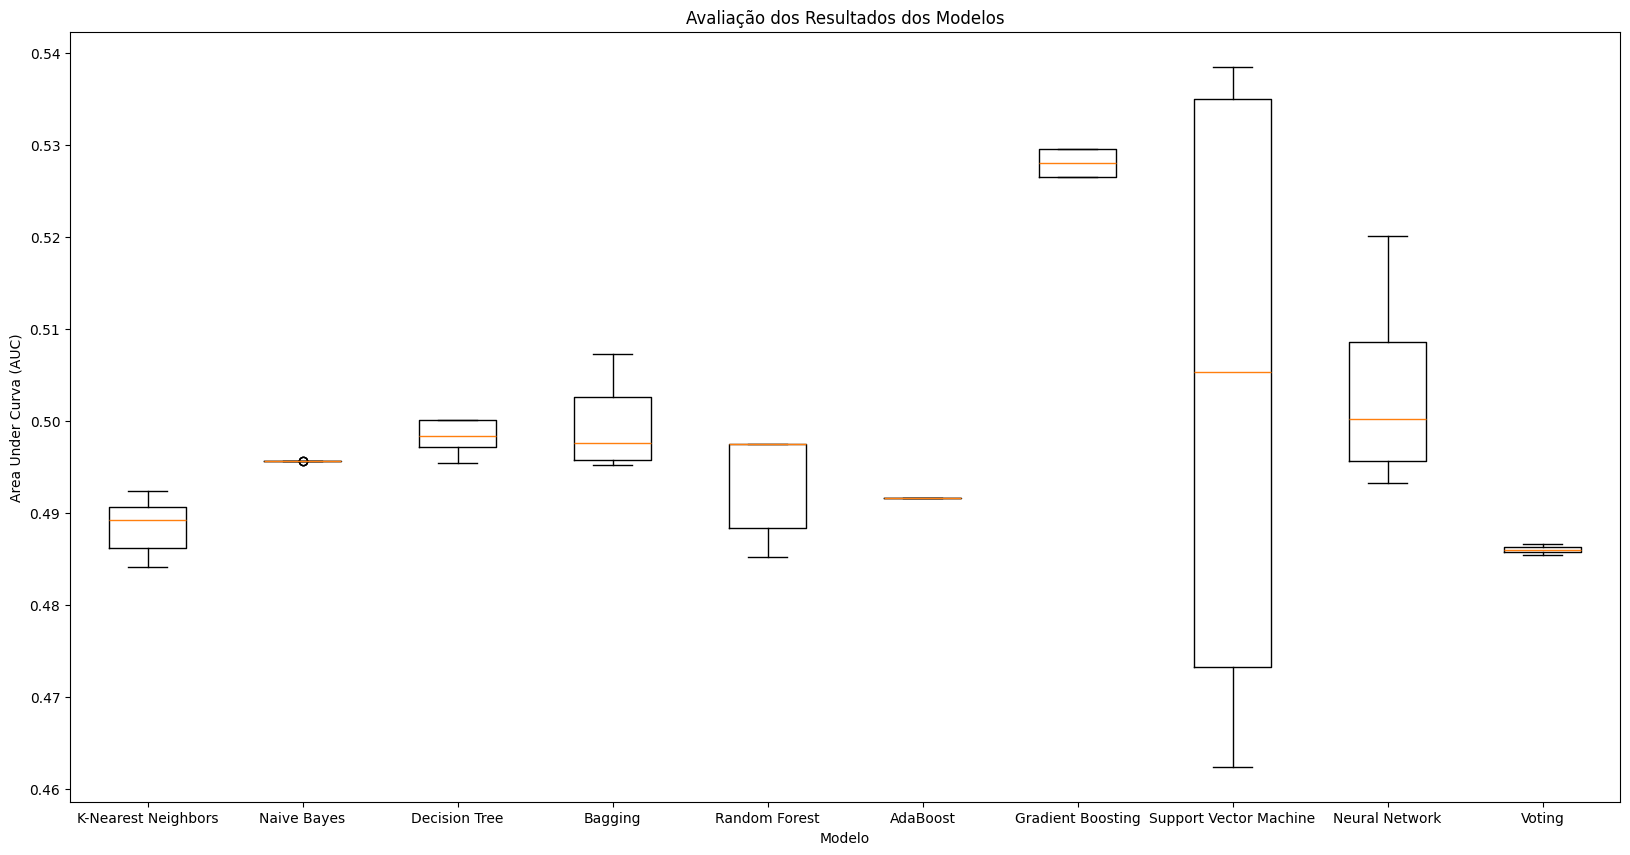

In [36]:
models = [knn, naive_bayes, decision_tree, bagging, random_forest, adaboost, gradient_boosting, svm, neural_network, voting]
labels = [knn_name, naive_bayes_name, decision_tree_name, bagging_name, random_forest_name, adaboost_name, gradient_boosting_name, svm_name, neural_network_name, voting_name]

scores = []
for model in models:
    scores.append(model.cv_results_['mean_test_score'])

plt.figure(figsize = (20, 10))
plt.boxplot(scores, labels = labels)
contextualize('Avaliação dos Resultados dos Modelos', 'Modelo', 'Area Under Curva (AUC)')

Observando o diagrama de caixa e bigodes para os resultados do desempenho de cada modelo, é possível comparar a consistência de cada uma das técnicas de modelação.

Efetivamente, verifica-se que os modelos de *ensemble* (particularmente *Random Forest*, *AdaBoost*, *Gradient Boosting* e *Voting*) são os melhores para o problema a tratar, dado que são aqueles que obtêm consistentemente a AUC mais elevada. De seguida, as técnicas de modelação *Bagging* e *Neural Network* são as que conseguem os melhores resultados. A *Decision Tree* e a *Support Vector Machine* demonstram uma clara instabilidade, sendo altamente dependentes dos hiper-parâmetros. Finalmente, os algoritmos *K-Nearest Neighbors* e *Naive Bayes* são aqueles que evidenciam um pior desempenho quanto à métrica de avaliação considerada.

Assim, é possível ordenar os modelos de acordo com a sua adequação aos objetivos do tema. O critério principal de avaliação é a área sobre a curva ROC, tal como definido anteriormente, de modo a aferir quão bem cada modelo distingue transações fraudulentas de transações legítimas. O critério de desempate (para modelos com igual AUC) é o valor obtido para *recall*, tendo em conta que é mais importante capturar todas as transações fraudulentas, ainda que correndo o risco de incluir algumas transações legítimas, do que só identificar as transações garantidamente fraudulentas, mas deixando escapar algumas transações fraudulentas. Em caso de igualdade nestas duas métricas, o terceiro critério utilizado para a ordenação será a precisão, visto que também é importante não considerar fraudulentas transações que são legítimas, na tentativa de minimizar o impacto desta deteção de fraude para os utilizadores legítimos.

Deste modo, a ordem dos modelos - do mais adequado para o menos adequado - é a seguinte:
1. *Gradient Boosting*
2. *Voting*
3. *Neural Network*
4. *AdaBoost*
5. *Random Forest*
6. *Bagging*
7. *Support Vector Machine*
8. *Decision Tree*
9. *Naive Bayes*
10. *K-Nearest Neighbors*

No geral, estes resultados parecem satisfazer os objetivos pretendidos para o tema, dado que os seis primeiros modelos conseguem distinguir bastante bem transações fraudulentas de legítimas, dado que a AUC obtida está próxima de 1. Para além disso, metade destes modelos têm também uma precisão perfeita (100%) e um valor de *recall* elevado (70%), o que viabiliza a sua aplicação prática em contexto real.

### Revisão do Processo

No final do processo de aprendizagem computacional, torna-se oportuno e adequado efetuar uma reflexão/revisão sobre todo o trabalho desenvolvido, destacando as atividades principais e as decisões tomadas em cada fase, considerando aspetos positivos e aspetos a melhorar.

1. **Compreensão do Tema:** Nesta fase, estabeleceram-se os objetivos do tema e os objetivos de mineração de dados. Efetivamente, esta etapa foi crucial para clarificar aquilo que se pretendia do projeto a desenvolver, através da definição dos critérios de sucesso do mesmo. Assim, foi importante tornar claro aquilo que se considerava uma "fraude" e que deveria ser detetado pelo modelo, bem como qual era a importância do desenvolvimento do mesmo. Não se verificaram dificuldades, nem aspetos a melhorar no futuro.

2. **Compreensão dos Dados:** Esta etapa - extremamente abrangente e demorada - teve como propósito aumentar o conhecimento sobre o domínio e, em particular, sobre os dados a tratar, permitindo a formulação de hipóteses/teorias e a extração de conclusões. Nesse sentido, a elaboração de vários gráficos e tabelas permitiu responder às questões colocadas através de análises estatísticas descritivas. Para além disso, a reflexão sobre a plausibilidade de alguns valores, assim como a aferição da qualidade dos dados, foram elementos essenciais para realizar uma boa preparação do conjunto de dados, resultando, posteriormente, numa boa modelação. No futuro, talvez pudessem ser formalizadas mais teorias e levantadas mais questões/hipóteses sobre os dados e o problema a tratar, procurando, desse modo, ter um ainda maior conhecimento do domínio, para uma ainda melhor modelação.

3. **Preparação dos Dados:** Neste momento, os dados foram selecionados, limpos, construídos/transformados, integrados e formatados. Isto foi essencial para possibilitar a aplicação das diferentes técnicas de modelação, garantido que os dados estavam prontos para serem ingeridos pelos diferentes modelos. Ora, este processo foi ligeiramente desafiante, principalmente no sentido de determinar que funcionalidades fariam sentido serem criadas seguindo uma metodologia de engenharia de funcionalidades, pelo que, em trabalhos posteriores, pode ser relevante procurar mais informações com peritos do domínio em questão. Ainda que todas as decisões tenham sido devidamente fundamentadas e justificadas, admite-se que, em eventuais iterações futuras, estas possam ser tomadas de forma diferente, tendo em vista a obtenção de melhores resultados. Por exemplo, a imputação do valor *unknown* para as transações com sistema operativo em falta poderia também ter sido feita com o valor mais comum para este atributo nas transações semelhantes, o que retornaria resultados diferentes. Para além disso, poderia ter sido criada uma *pipeline* que automatizasse todo este processo de preparação dos dados, tal como será feito na fase de produção.

4. **Modelação Preditiva:** Esta parte - central e imprescindível - serviu para desenvolver os dez modelos de classificação a testar: *K-Nearest Neighbors*, *Naive Bayes*, *Decision Tree*, *Bagging*, *Random Forest*, *AdaBoost*, *Gradient Boosting*, *Support Vector Machine*, *Neural Network* e *Voting*. Todas estas técnicas de modelação foram treinadas e testadas contra um *design* de teste previamente elaborado, para que pudessem ser avaliadas e comparadas devidamente. Assim, foram determinados os valores de várias métricas de avaliação (dando particular destaque à AUC) para cada um dos algoritmos considerados e afinados os hiper-parâmetros com uma *grid search*, tendo em vista a maximização do valor da área sobre a curva ROC. Se o tempo o permitir, trabalhos futuros podem explorar ainda mais modelos, bem como afiná-los com hiper-parâmetros distintos e/ou fornecendo-lhes dados diferentes. Ainda assim, esta etapa pode ser considerada globalmente completa e bem-sucedida.

5. **Avaliação:** Finalmente, a última secção permitiu comparar os resultados obtidos pelos diferentes modelos e verificar a sua adequação aos objetivos do tema, tendo em vista a definição de qual o modelo com melhor desempenho. Assim, concluiu-se o processo de aprendizagem computacional de forma apropriada, resumindo e agregando os resultados e evidenciando-os de forma clara.

### Determinação dos Próximos Passos

Concluído todo o processo, resta seguir para a fase de produção, não sem antes resumir os aspetos que podem ser considerados em iterações futuras deste mesmo projeto.

Em síntese, podem ser exploradas diferentes variações dos dados fornecidos ao modelo, seja pela remoção ou manutenção de determinados atributos, seja pela criação de novas e diferentes funcionalidades. Em particular, este aspeto talvez seja o mais importante a considerar em trabalhos futuros, tendo em vista a obtenção de melhores resultados. A par disso, pode também ser desenvolvida uma *pipeline* para otimizar todo o processo de preparação de dados, como se fará agora para a entrada em produção do modelo.

Não havendo nada mais a tratar, avança-se para o momento final do projeto.

## Produção

Tendo treinado, testado e avaliado os modelos, bem como estabelecido a sua ordem de adequação ao problema de mineração de dados a tratar, tendo em conta o desempenho obtido, o modelo considerado final deve ser colocado em produção, isto é, ser submetido na competição do *Kaggle* presente neste *link*: https://www.kaggle.com/competitions/fraud-detection-cc-4036-2425.

Os ficheiros de dados relevantes encontram-se no diretório **kaggle**, sendo os seguintes:
1. **customers.csv:** ficheiro de clientes devidamente tratado, guardado/exportado após o final da *Task 1*
2. **merchants.csv:** ficheiro de comerciantes devidamente tratado, guardado/exportado após o final da *Task 1*
3. **test_transactions.csv:** transações não classificadas, com as quais o modelo será testado na competição do *Kaggle*

Assim, os dados presentes no ficheiro **test_transaction** devem ser devidamente selecionados, limpos, construídos, integrados e formatados, de acordo com o procedimento seguido na *Task 1*, sendo, agora, efetuado através de uma *pipeline*.

In [37]:
customers = pd.read_csv('kaggle/customers.csv')
merchants = pd.read_csv('kaggle/merchants.csv')
transactions = pd.read_csv('kaggle/test_transactions.csv')

def data_selection(transactions):
    return transactions.drop(['trans_date_trans_time', 'device_os'], axis = 1)

def data_cleaning(transactions):
    return transactions.drop(['trans_num'], axis = 1)

def data_construction(transactions):
    timestamp = pd.to_datetime(transactions['unix_time'], unit = 's')
    
    month = (timestamp.dt.month - 1) * (2 * np.pi / 12)
    transactions['month_sin'] = round(np.sin(month), 3)
    transactions['month_cos'] = round(np.cos(month), 3)

    weekday = timestamp.dt.weekday * (2 * np.pi / 7)
    transactions['weekday_sin'] = round(np.sin(weekday), 3)
    transactions['weekday_cos'] = round(np.cos(weekday), 3)

    transactions = transactions.sort_values(by = ['cc_num', 'unix_time'])
    transactions['days_since_last_transaction'] = transactions.groupby('cc_num')['unix_time'].diff()
    transactions['days_since_last_transaction'] = round(transactions['days_since_last_transaction'] / (60 * 60 * 24), 3)
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'].fillna(0)

    transactions = transactions.sort_values(by = ['cc_num', 'merchant', 'unix_time'])
    transactions['merchant_transactions_count'] = transactions.groupby(['cc_num', 'merchant']).cumcount()

    return transactions

def data_integration(transactions, merchants, customers):
    data = transactions.merge(merchants, on = 'merchant').merge(customers, on = 'cc_num')
    data['age'] = pd.to_datetime(data['unix_time'], unit = 's').dt.year - pd.to_datetime(data['dob']).dt.year
    data['city_NewYork'] = (data['city'] == 'New York').astype(int)
    data = data.drop(['dob', 'unix_time', 'cc_num', 'job', 'category', 'gender', 'city'], axis = 1)
    return data

def data_formatting(test_data):
    test_data = test_data.drop('merchant', axis = 1)
    test_data = pd.get_dummies(test_data, drop_first = True)
    test_data = test_data.sort_index(axis = 1)
    return test_data

test_data = transactions.pipe(data_selection).pipe(data_cleaning).pipe(data_construction).pipe(data_integration, merchants, customers).pipe(data_formatting)
test_data.head()

,age,amt,city_NewYork,days_since_last_transaction,index,merchant_transactions_count,month_cos,month_sin,weekday_cos,weekday_sin
0,30,483.368265,0,0.0,31604,0,0.866,-0.500,-0.223,0.975
1,20,236.803300,0,171.0,30246,0,-0.866,-0.500,-0.901,0.434
2,20,181.193456,0,0.0,30526,0,0.866,0.500,1.000,0.000
3,28,22.241488,0,0.0,30566,0,-0.500,-0.866,-0.223,-0.975
4,68,293.482287,0,0.0,30106,0,1.000,0.000,0.623,0.782


Finalmente, as transações a testar na competição do *Kaggle* devem ser submetidas ao modelo a colocar em produção, para que seja prevista a probabilidade de cada transação ser fraudulenta ou legítima, isto é, a probabilidade da variável-alvo *is_fraud*.

In [38]:
model = voting
model_name = voting_name
model_auc = voting_auc

print(model_name, '- AUC Pós-Afinação: {:.2f}'.format(model_auc))

scaler = MinMaxScaler()
scaler.fit(train_predictors)
scaled_test_data = scaler.transform(test_data.drop('index', axis = 1))

probabilities = model.predict_proba(scaled_test_data)[:, 1]

predictions = pd.DataFrame({
    'index': test_data['index'],
    'is_fraud': probabilities
})

predictions.to_csv('kaggle/submission.csv', index = False)

Voting - AUC Pós-Afinação: 0.56


O resultado submetido na competição do *Kaggle* encontra-se no ficheiro **predictions.csv**, dentro do diretório **kaggle**.

Assim, considera-se concluído o projeto.